# Testing out splitting methods for solving RD-PDE

## Objectives 
* write simple blocks of code that implement different operator splitting approaches in for loops and such, just to give you the sense of how to write code like this. 
* if possible, include convergence rate estimates.
* no need to optimize running speed, maybe just keep track of function and jacobian evaluations if needed. 
* you'll also need a different omnisim.py to import that includes separated reaction and diffusion RHS functions. 



## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 

In [52]:
# imports
from __future__ import division, print_function

import itertools as itt

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

%load_ext memory_profiler
%load_ext line_profiler
import timeit

from IPython.display import HTML

%matplotlib inline

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(6)
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(1,3, figsize=(10,7))
    im_list = [0,0,0]
    
    # Plot cell densities
    ax = axs[0]
    indxs = [cp_i, cs_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[1]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[1] = im
    
    # Plot pulser synthase densities
    ax = axs[2]
    indxs = [s_i, cp_i]
    v_arr = im_arr[:,indxs,:,w//2:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[2] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cp_i, cs_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
    fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
        A[ind,:,:] += cell_arr
#         A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A



In [53]:
import importlib
import split_omnisim as oms
oms = importlib.reload(oms)

# Params :    ,Dc,    rc,  rp,   Kn,   Dn,  kn,  Da,  xa,    xs,  xS,
p0 = np.array([0,    8e-3, 8e-3, 15,  3e-2,  1, 3e-2, 8e-2, 5e2, 2e2, 
#xr,   hS,   kS,  hR, kR,  hC,  kC,    pa,  colthresh   od0
1.2e3, 3.2, 100, 2.3, 55, 3.2, 2.7e3, 5e-3, 1e-3, 0.1], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,col_thresh,od0 = p0

simmer = oms.Simulator()
simmer.set_scale(4)
simmer.t_eval = np.arange(0,2*60,5)
species, nh, nw, _ = simmer.dims
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(species)
scale = simmer.scale
# Setup initial conditions
initial_array = np.zeros((species, nh, nw), dtype=np.float64, order='C')# + 1e-7
initial_array[n_i,:,:] = 100
initial_array[cs_i,scale:-scale,scale:2*scale] = od0
initial_array[cs_i,:,:] = ndi.gaussian_filter(initial_array[cs_i,:,:], scale/4)
initial_array[cp_i,scale:-scale,2*scale:-scale] = od0
initial_array[cp_i,:,:] = ndi.gaussian_filter(initial_array[cp_i,:,:], scale/4)

simmer.initial_array = initial_array
simmer.sim(p0)
im_arr = simmer.sim_arr
t_vec = simmer.sim_tvc
# anim = write_movie(im_arr, t_vec)
# print('random initial')

/home/jmp/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


In [54]:
anim = write_movie(im_arr, t_vec)
HTML(anim.to_html5_video())

In [14]:
simmer.out

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115])
 t_events: None
        y: array([[1.12384321e-08, 1.16930399e-08, 1.21660371e-08, ...,
        2.58441136e-08, 2.68895403e-08, 2.79772567e-08],
       [3.35012940e-05, 3.48564607e-05, 3.62664455e-05, ...,
        7.70401844e-05, 8.01565523e-05, 8.33989831e-05],
       [1.12384321e-08, 1.16930399e-08, 1.21660371e-08, ...,
        2.58441027e-08, 2.68895277e-08, 2.79772420e-08],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ..

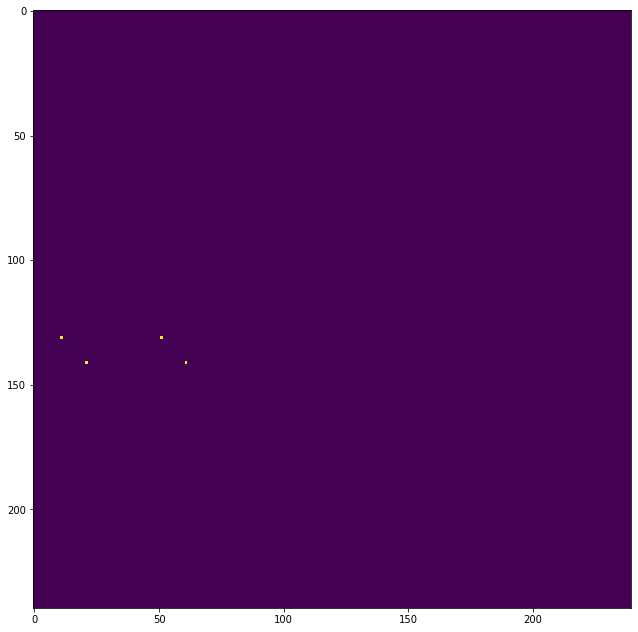

In [20]:
y = im_arr[10,:,:,:]
# y.shape = (species, nh, nw)
dy = np.zeros_like(y)
diff_terms = np.zeros_like(y)
nut_avail = np.zeros_like(y[0,:,:])
oms.calc_f(y, dy, diff_terms, nut_avail, simmer.params)
# dy[s_i,:,:].max()
# plt.imshow(y[s_i,:,:])
plt.figure(figsize=(11,11))
jac_arr = simmer.jacobian.calc_jac_wrapper(0,y.flatten()).toarray()
plt.imshow(np.abs(jac_arr))

In [18]:
y = initial_array
jac = simmer.jacobian.calc_jac_wrapper(0,y)
# i suppose use numpy's check_grad utility against the jacobian
bads = []
goods = []
species, nh, nw, _ = simmer.dims
for i in np.arange(species*nh*nw):
    f_lam = lambda y0 : simmer.f_ivp_wrapper(0,y0)[i]
    g_lam = lambda y0 : simmer.jacobian.calc_jac_wrapper(0,y0).toarray()[i,:]
#     err = opt.check_grad(f_lam, g_lam, y)
    err = opt.approx_fprime(y, f_lam,1e-8) - g_lam(y)
    bad_dus = np.arange(len(err))[err>1e-7]
    if np.all(np.isclose(0,err)):
        goods.append(i)
    else:
        for bad_du in bad_dus:
            u = bad_du // (nw*nh)
            bads.append((i//(nw*nh),u))

In [19]:
print(bads)

[]


For a first test, instantiate a BDF and a RK solver and use them to perform the separate diffusion and reaction steps. Each of these are written in python, so I expect running this in a for-loop should not drastically change the runtime.

In [37]:
from solvers import rk, bdf
# Diffusion jacobian. 
n_jac = np.prod(simmer.jacobian.dims[:-1])
vals, j1, j2 = simmer.jacobian.dif_vec, simmer.jacobian.j1_dif, simmer.jacobian.j2_dif
dif_jac = sparse.coo_matrix((vals, (j1, j2)), shape=(n_jac,n_jac),dtype=np.float64)
y = initial_array.copy()
rk_solver = rk.RK45(simmer.f_rxn_wrapper, 0, y.flatten(), 2*60,first_step=1, max_step=5, vectorized=True)
bdf_solver = bdf.BDF(simmer.f_dif_wrapper, 0, y.flatten(), 2*60, max_step=5, jac=dif_jac, vectorized=True)
t = 0
failed = False
while not failed and t < 2*60:
    bdf_solver._step_impl()
    k
    rk_solver._step_impl()
    


In [38]:
rk_solver._step_impl()

(True, None)

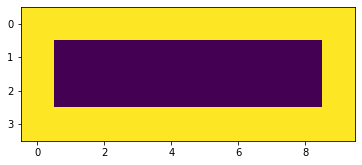

In [49]:
plt.imshow(rk_solver.y.reshape((species,nh,nw))[2,:,:])